In [ ]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
bs = 100

seed = 42
torch.manual_seed(seed)

In [ ]:
# Data Preprocessing
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,))])
# trainTransform  = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data',  train=True,download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=8, pin_memory=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=8, pin_memory=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
len(trainset), len(testset)

(60000, 10000)

In [ ]:
def save_model(model, path, optimizer=None):
    """
    Saves the state_dict of a torch model and optional optimizer to 'path'
    Returns: None
    """
    state = {"model": model.state_dict()}
    if optimizer is not None:
        state["optimizer"] = optimizer.state_dict()
    torch.save(state, path)


def load_model(model, path, optimizer=None):
    """
    Loads the state_dict of a torch model and optional optimizer from 'path'
    Returns: None
    """
    state = torch.load(path)
    model.load_state_dict(state["model"])
    if optimizer is not None:
        optimizer.load_state_dict(state["optimizer"])


In [ ]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [ ]:
# build network
z_dim = 100
mnist_dim = 784

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

In [ ]:
G, D

(Generator(
   (fc1): Linear(in_features=100, out_features=256, bias=True)
   (fc2): Linear(in_features=256, out_features=512, bias=True)
   (fc3): Linear(in_features=512, out_features=1024, bias=True)
   (fc4): Linear(in_features=1024, out_features=784, bias=True)
 ), Discriminator(
   (fc1): Linear(in_features=784, out_features=1024, bias=True)
   (fc2): Linear(in_features=1024, out_features=512, bias=True)
   (fc3): Linear(in_features=512, out_features=256, bias=True)
   (fc4): Linear(in_features=256, out_features=1, bias=True)
 ))

In [ ]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [ ]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [ ]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [ ]:
n_epoch = 100
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

    if (epoch+1) % n_epoch == 0:
        save_model(model=G, path=f"./gan_gen_epoch_{epoch+1}.ckpt")
        save_model(model=D, path=f"./gan_dis_epoch_{epoch+1}.ckpt")

In [ ]:
test_examples = None

with torch.no_grad():
    for data in test_loader:
        img, label = data
        test_examples = Variable(img).cuda()
        noise = Variable(torch.randn(bs, z_dim).cuda())
        reconstruction = G(noise)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


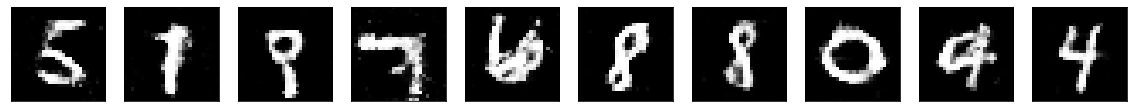

In [ ]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        #ax = plt.subplot(2, number, index + 1)
        #plt.imshow(test_examples[index].cpu().numpy().reshape(28, 28))
        #plt.gray()
        #ax.get_xaxis().set_visible(False)
        #ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].cpu().numpy().reshape(28, 28), cmap='gray')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [ ]:
class Discriminator_Classifier(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator_Classifier, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc = nn.Sequential(
                nn.Linear(256, 128, bias=True),
                nn.ReLU(True),
                nn.Linear(128, 10, bias=True))
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return self.fc(x)

In [ ]:
classifier = Discriminator_Classifier(mnist_dim).to(device)
print(classifier)
pre_dis = Discriminator(mnist_dim).to(device)
load_model(pre_dis, "./gan_dis_epoch_100.ckpt")

# 得到 ae_classifier 的目前的参数
classifier_dict = classifier.state_dict()
# 如果 pre_ae 的dict参数在新的 classifier ae里存在，就保存下来
pre = {k: v for k, v in pre_dis.state_dict().items() if k in classifier_dict}

Discriminator_Classifier(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def train_classifier(net, train_iter, criterion, optimizer):
    if isinstance(net, nn.Module):
        net.train()
    loss_record = 0
    total = 0
    for batch_idx, data in enumerate (train_iter, 0):
        # print(len(train_iter))
        img, labels = data
        img = img.view(-1, mnist_dim)
        label = Variable(labels)
        img = img.to(device=try_gpu())
        label = label.to(device=try_gpu())
        # ===================forward=====================
        output = net(img)
        loss = criterion(output, label)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_record += loss
        total += 1
    # ===================log========================
    return loss_record / total

def eval_accuracy(net, data_iter, criterion):
    if isinstance(net, nn.Module):
        net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, target in data_iter:
            eval_imgs = Variable(data).cuda()
            eval_imgs = eval_imgs.view(-1, mnist_dim)
            # output = model(img)
            target = Variable(target).cuda()
            output = net(eval_imgs)
            # target = target.to(device=try_gpu())
            pred = output.max(dim=1)[1]
            # print(pred)
            # print(target)
            correct += (pred == target).sum().item()

            total += target.size(0)
            # print(total)
        return correct / total

In [ ]:
import numpy as np

for name, param in classifier.named_parameters():
    if param.requires_grad and "encoder" in name:
        param.requires_grad =False

num_epochs = 10
# Learning_rate = 0.0005
classifier_criterion = nn.CrossEntropyLoss().to(device)
classifier_optimizer = optim.Adam(classifier.parameters(), lr = lr)

DC_losses, DC_accuracy = [], []
for epoch in range(num_epochs):
  ecoch_val_loss = train_classifier(classifier, train_loader, classifier_criterion, classifier_optimizer)
  DC_losses.append(ecoch_val_loss)
  epoch_val_acc = eval_accuracy(classifier, test_loader, classifier_criterion)
  DC_accuracy.append(epoch_val_acc)
  print('[%d/%d]: loss_dc: %.4f' % (
            (epoch), num_epochs, ecoch_val_loss))
  print('[%d/%d]: accu_d: %.4f' % (
            (epoch), num_epochs, epoch_val_acc))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[0/10]: loss_dc: 0.076
[0/10]: accu_d: 0.970
[1/10]: loss_dc: 0.070
[1/10]: accu_d: 0.971
[2/10]: loss_dc: 0.069
[2/10]: accu_d: 0.974
[3/10]: loss_dc: 0.063
[3/10]: accu_d: 0.973
[4/10]: loss_dc: 0.063
[4/10]: accu_d: 0.971
[5/10]: loss_dc: 0.060
[5/10]: accu_d: 0.973
[6/10]: loss_dc: 0.057
[6/10]: accu_d: 0.973
[7/10]: loss_dc: 0.057
[7/10]: accu_d: 0.973
[8/10]: loss_dc: 0.052
[8/10]: accu_d: 0.974
[9/10]: loss_dc: 0.050
[9/10]: accu_d: 0.976
